# NYC Open Data - Spatial Joins
Joining data from NYC Open Data to street segments. 
Three parts:

This is done with the entire city to show how to do it in a more efficient way.

1. Data Ingestion
2. Spatial Join of Open Data to Road Segments
3. Aggregating data by osmid 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import rtree

from shapely.geometry import Point, box
from shapely import wkt

from fiona.crs import from_epsg
%matplotlib inline

## Farmer's Markets ##

Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

What does few vs some/a lot mean in this case?

### I. Import shapefiles and convert to appropriate coordinate system

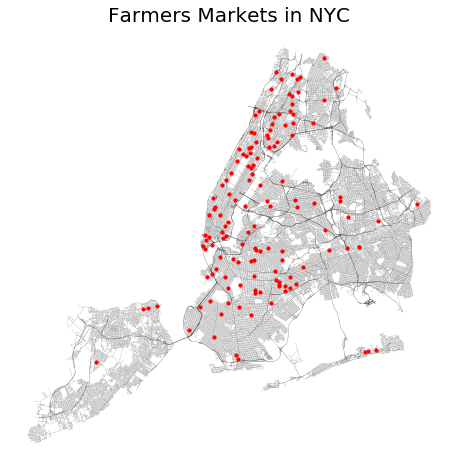

In [2]:
# Ingest data and convert to long island state plane so we can use ft as units
segs = gpd.read_file('../road_network_data/osm/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
nodes = gpd.read_file('../road_network_data/osm/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})

# Get schools from CSV
markets = pd.read_csv('Datasets (from NYC open data)/farmers_markets.csv')

#Transform to GeoDataFrame
markets['geometry'] = markets.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
markets = gpd.GeoDataFrame(markets, crs=from_epsg(4326)).to_crs(epsg=2263)

#Remove market with nonsense location (only one)
markets = markets[(markets.Latitude > 0)]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Farmers Markets in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1, alpha=0.5)
#nodes.plot(markersize=0.1, ax= ax)
markets.plot(color='red', markersize=10, ax=ax)
ax.axis('off')

plt.show()

In [3]:
markets.head()

,Borough,Market Name,Street Address,Latitude,Longitude,Days of Operation,Hours of Operations,Season Dates,Accepts EBT,Open Year-Round,Stellar Cooking Demonstrations,Food Activities for Kids,Location Point,geometry
0,Bronx,170 Farm Stand,E 170th St & Townsend Ave,40.839882,-73.916783,Wednesday,2:30 - 6:30 p.m.,07/10/2019-11/27/2019,Yes,No,No,Yes,"(40.839882, -73.916783)",POINT (1007276.059907538 245279.9566388851)
1,Bronx,Bissel Gardens Farmers Market,Baychester Ave & E 241st St,40.901520,-73.846937,Wednesday & Saturday,9 a.m. - 5 p.m.,07/06/2019-11/27/2019,No,No,No,No,"(40.90152, -73.846937)",POINT (1026563.121955398 267763.1360158126)
2,Bronx,Bronx Borough Hall Greenmarket,Grand Concourse bet E 161st & 162nd Sts,40.826835,-73.922621,Tuesday,8 a.m. - 4 p.m.,06/04/19-11/26/19,Yes,No,Yes,No,"(40.826835, -73.922621)",POINT (1005664.890642698 240524.9734403558)
3,Bronx,Bronx Family Center Go!Healthy Farm Stand,1515 Southern Blvd,40.833734,-73.889934,Thursday,9:30 a.m. - 3:30 p.m.,07/11/2019-11/21/2019,Yes,No,No,Yes,"(40.833734, -73.889934)",POINT (1014707.96216763 243048.2096178664)
4,Bronx,BronxWorks Farm Stand,1130 Grand Concourse,40.832331,-73.919590,Thursday,10 a.m. -4 p.m.,07/08/2019-11/22/2019,Yes,No,No,No,"(40.832331, -73.91959)",POINT (1006501.891447249 242528.1227422342)


### II. "Spatially join" to road data 

#### First create an Rtree index to make the search faster

In [4]:
index = rtree.Rtree()
for idx, geometry in enumerate(segs.geometry):
    index.insert(idx, geometry.bounds)

def closest_segment_id_rtree(point, index, segments):
    match = list(index.nearest((point.x, point.y, point.x, point.y)))
    if len(match):
        return segments.loc[segments.loc[match, 'geometry'].distance(point).idxmin(),'id']
    else:
        return None
    
def closest_segment_id(point, segments):
    return segments.loc[segments.geometry.distance(point).idxmin(),'id']

In [5]:
len(segs), len(markets)

(91666, 138)

In [6]:
%time markets['segid'] = markets.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 990 ms, sys: 30 ms, total: 1.02 s
Wall time: 1.01 s


In [7]:
markets.segid.isna().sum()

0

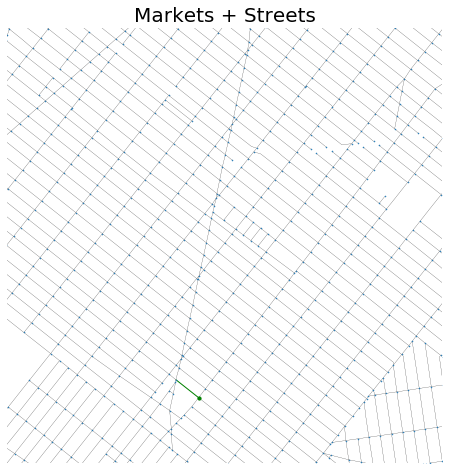

In [8]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(12,8))

matched_segids = markets.segid.unique()

ax.set_title('Markets + Streets', fontsize=20)
segs[segs.id.isin(matched_segids)].plot(color='green', ax= ax, lw=1, zorder=-1)
segs[~segs.id.isin(matched_segids)].plot(color='black', ax= ax, lw=0.2, zorder=-1)
nodes.plot(markersize=0.3, ax= ax)
markets.plot(color='green', markersize=10, ax=ax)

ax.set_xlim(980000, 990000)
ax.set_ylim(160000, 170000)
ax.axis('off')

plt.show()

### III. Aggregate to SoP variables per segment


In [9]:
# available columns
markets.columns

Index(['Borough', 'Market Name', 'Street Address', 'Latitude', 'Longitude',
       'Days of Operation', 'Hours of Operations', 'Season Dates',
       'Accepts EBT', 'Open Year-Round', 'Stellar Cooking Demonstrations',
       'Food Activities for Kids', 'Location Point', 'geometry', 'segid'],
      dtype='object')

In [19]:
markets.groupby('segid')['Market Name'].count().describe()

count    138.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Market Name, dtype: float64

Of course there's only one per street (where there is any)

In [12]:
markets_var = pd.DataFrame(index=markets.segid.unique(), columns=['farnermk']).fillna(1)
markets_var.index.name = 'segid'
markets_var.head()

,farnermk
segid,
11907,1
10650,1
28004,1
28345,1
19049,1


## Bus Stop Shelters ##

Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

What does few vs some/a lot mean in this case?

In [60]:
#I'll define few as 3 or less (but not 0)
few = 3

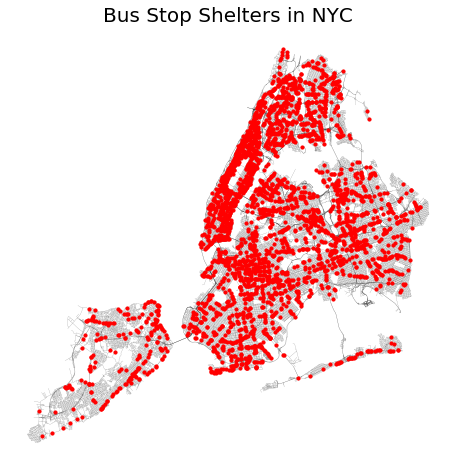

In [13]:
# Get shelters from CSV
shelters = gpd.read_file('Datasets (from NYC open data)/bus_stop_shelter.shp').to_crs({'init': 'epsg:2263'})

#Remove shelters without location 
shelters = shelters[~shelters.latitude.isna()]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Bus Stop Shelters in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1, alpha=0.5)
#nodes.plot(markersize=0.1, ax= ax)
shelters.plot(color='red', markersize=10, ax=ax)
ax.axis('off')

plt.show()

### II. "Spatially join" to road data

In [14]:
len(segs), len(shelters)

(91666, 3428)

In [15]:
%time shelters['segid'] = shelters.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 15 s, sys: 80 ms, total: 15.1 s
Wall time: 15.1 s


In [16]:
shelters.segid.isna().sum()

0

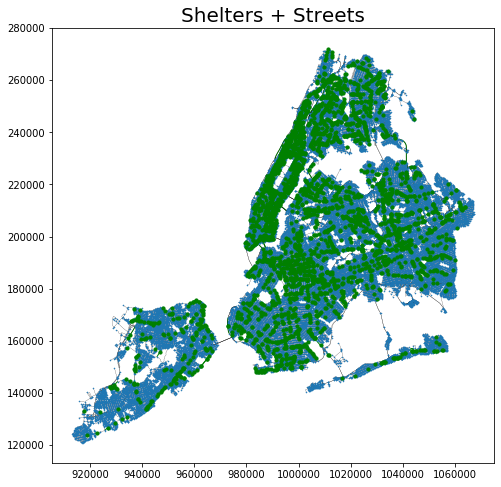

In [17]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(12,8))

matched_segids = shelters.segid.unique()

ax.set_title('Shelters + Streets', fontsize=20)
segs[segs.id.isin(matched_segids)].plot(color='green', ax= ax, lw=1, zorder=-1)
segs[~segs.id.isin(matched_segids)].plot(color='black', ax= ax, lw=0.2, zorder=-1)
nodes.plot(markersize=0.3, ax= ax)
shelters.plot(color='green', markersize=10, ax=ax)

#ax.set_xlim(980000, 990000)
#ax.set_ylim(160000, 170000)
#ax.axis('off')

plt.show()

### III. Aggregate shelters to SoP variables per segment


In [18]:
# available columns
shelters.columns

Index(['assem_dist', 'asset_id', 'at_between', 'boro_cd', 'boro_code',
       'boro_name', 'cong_dist', 'coun_dist', 'latitude', 'location',
       'longitude', 'nodeid', 'physical_i', 'segment_id', 'shelter_id',
       'st_sen_dis', 'street', 'geometry', 'segid'],
      dtype='object')

In [20]:
shelters.groupby('segid')['asset_id'].count().describe()

count    2988.000000
mean        1.147256
std         0.450126
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: asset_id, dtype: float64

Most of them have 1...

In [62]:
shelters_var = shelters.groupby('segid')[['asset_id']].count()
shelters_var.columns = ['busstops']
shelters_var['busstops'] = shelters_var.busstops.apply(lambda x: 2 if x > few else 1 if x > 0 else 0)
shelters_var.head()

,busstops
segid,
17,1
64,1
66,1
78,1
83,1


In [63]:
shelters_var.busstops.value_counts()

1    2973
2      15
Name: busstops, dtype: int64

In [64]:
# shelters_var = pd.DataFrame(index=shelters.segid.unique(), columns=['busstops']).fillna(1)
# shelters_var.index.name = 'segid'
# shelters_var.head()

## City Bench ##


Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

What does few vs some/a lot mean in this case?

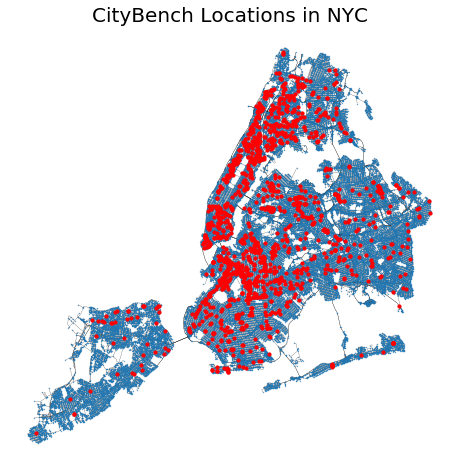

In [65]:
# Get benches from CSV
benches = gpd.read_file('Datasets (from NYC open data)/NYC_CityBench.shp').to_crs({'init': 'epsg:2263'})

#Remove benches without location 
#benches = benches[~benches.latitude.isna()]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('CityBench Locations in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
nodes.plot(markersize=0.1, ax= ax)
benches.plot(color='red', markersize=10, ax=ax)
ax.axis('off')

plt.show()

### II. "Spatially join" to road data 

In [66]:
len(segs), len(benches)

(91666, 1602)

In [67]:
%time benches['segid'] = benches.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 7.93 s, sys: 80 ms, total: 8.01 s
Wall time: 8 s


In [68]:
benches.segid.isna().sum()

0

### III. Aggregate to SoP variables per segment

In [69]:
benches.columns

Index(['OBJECTID_1', 'SiteID', 'BenchID', 'Category', 'Type', 'Installati',
       'Address', 'Street', 'X_Street', 'Borough', 'ComDist', 'Bus_Route',
       'geometry', 'segid'],
      dtype='object')

In [70]:
benches.groupby('segid')['BenchID'].count().describe()

count    1299.000000
mean        1.233256
std         0.801733
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        13.000000
Name: BenchID, dtype: float64

Again, most of them have 1...

In [73]:
benches_var = benches.groupby('segid')[['BenchID']].count()
benches_var.columns = ['benches']
benches_var['benches'] = benches_var.benches.apply(lambda x: 2 if x > few else 1 if x > 0 else 0)
benches_var.head()

,benches
segid,
16,1
95,1
124,1
129,1
215,1


In [75]:
benches_var.benches.value_counts()

1    1272
2      27
Name: benches, dtype: int64

In [81]:
# benches_var = pd.DataFrame(index=benches.segid.unique(), columns=['benches']).fillna(1)
# benches_var.index.name = 'segid'
# benches_var.head()

## Sidewalk Cafes ##


Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

What does few vs some/a lot mean in this case?

In [29]:
# Get sidewalk cafes from CSV
cafes = pd.read_csv('Datasets (from NYC open data)/Sidewalk_Caf__Licenses_and_Applications.csv')
cafes.head()

,LICENSE_NBR,LIC_STATUS,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,CITY,STATE,ZIP,SWC_TYPE,...,HEARING,HEARING_DD,HEARING_PUBLIC,HEARING_PUBLIC_DD,CC,CC_DD,MOO,MOO_DD,ISSUANCE,ISSUANCE_DD
0,2021901-DCA,Inactive,NICOBAR LTD,NaN,10420,METROPOLITAN AVE,FOREST HILLS,NY,11375,NaN,...,Waived,06/05/2017,NaN,NaN,Review Period Expired,06/26/2017,NaN,NaN,Issued,03/07/2018
1,2038092-DCA,Active,AMITY HALL UPTOWN INC.,AMITY HALL,982,AMSTERDAM AVE,NEW YORK,NY,10025,NaN,...,Waived,01/24/2019,NaN,NaN,Review Period Expired,02/14/2019,Approved,05/02/2019,Issued,05/02/2019
2,2037395-DCA,Inactive,E & R U.S. VENTURES LLC,HUMMUS KITCHEN,444,3RD AVE,NEW YORK,NY,10016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Issued,10/03/2017
3,NaN,Inactive,CHARLEY ST. INC,CHARLYE ST.,41,KENMARE ST,NEW YORK,NY,10012,NaN,...,Recommendation Issued,12/13/2018,SWC Public Hearing,11/28/2018,Review Period Expired,01/03/2019,Pending Review,01/03/2019,Pending Review,NaN
4,2051490-DCA,Active,PRESTO FRESH CAFE CORP.,NaN,559,LENOX AVE,NEW YORK,NY,10037,NaN,...,Recommendation Issued,04/19/2017,SWC Public Hearing,04/05/2017,Review Period Expired,05/10/2017,Approved,06/16/2017,Issued,06/16/2017


In [30]:
# keep active cafes only
cafes = cafes[cafes.LIC_STATUS == 'Active']
cafes.head()

,LICENSE_NBR,LIC_STATUS,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,CITY,STATE,ZIP,SWC_TYPE,...,HEARING,HEARING_DD,HEARING_PUBLIC,HEARING_PUBLIC_DD,CC,CC_DD,MOO,MOO_DD,ISSUANCE,ISSUANCE_DD
1,2038092-DCA,Active,AMITY HALL UPTOWN INC.,AMITY HALL,982,AMSTERDAM AVE,NEW YORK,NY,10025,NaN,...,Waived,01/24/2019,NaN,NaN,Review Period Expired,02/14/2019,Approved,05/02/2019,Issued,05/02/2019
4,2051490-DCA,Active,PRESTO FRESH CAFE CORP.,NaN,559,LENOX AVE,NEW YORK,NY,10037,NaN,...,Recommendation Issued,04/19/2017,SWC Public Hearing,04/05/2017,Review Period Expired,05/10/2017,Approved,06/16/2017,Issued,06/16/2017
5,1258524-DCA,Active,88 2ND AVE. FOOD CORP.,THE KITCHEN SINK,88,2ND AVE,NEW YORK,NY,10003,NaN,...,Recommendation Issued,03/10/2015,SWC Public Hearing,NaN,Review Period Expired,06/01/2015,Approved,08/13/2015,Issued,01/14/2016
6,1421278-DCA,Active,BLUE SMOKE 102 NORTH END AVE LLC,BLUE SMOKE,255,VESEY ST,NEW YORK,NY,10281,NaN,...,Waived,01/10/2019,NaN,NaN,Review Period Expired,01/31/2019,Pending Review,NaN,Pending Review,NaN
7,2025568-DCA,Active,DEED LLC,EUGENE & CO,397,TOMPKINS AVE,BROOKLYN,NY,11216,NaN,...,Waived,01/10/2018,NaN,NaN,Review Period Expired,01/31/2018,Approved,04/25/2018,Issued,04/25/2018


In [31]:
cafes.columns

Index(['LICENSE_NBR', 'LIC_STATUS', 'BUSINESS_NAME', 'BUSINESS_NAME2',
       'BUILDING', 'STREET', 'CITY', 'STATE', 'ZIP', 'SWC_TYPE', 'SWC_SQ_FT',
       'SWC_TABLES', 'SWC_CHAIRS', 'DOHMH', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_DISTRICT', 'CITY_COUNCIL_DISTRICT', 'CD_URL', 'APP_ID',
       'APP_SWC_TYPE', 'APP_SQ_FT', 'APP_TABLES', 'APP_CHAIRS', 'APP_STATUS',
       'APP_STATUS_DATE', 'EXPIRATION_DATE', 'APP_TOO_DATE', 'SUBMIT_DATE',
       'INTAKE', 'INTAKE_DD', 'DPQA', 'SEND_PACKAGE_DD', 'CP', 'CP_DD', 'CB',
       'CB_DD', 'HEARING', 'HEARING_DD', 'HEARING_PUBLIC', 'HEARING_PUBLIC_DD',
       'CC', 'CC_DD', 'MOO', 'MOO_DD', 'ISSUANCE', 'ISSUANCE_DD'],
      dtype='object')

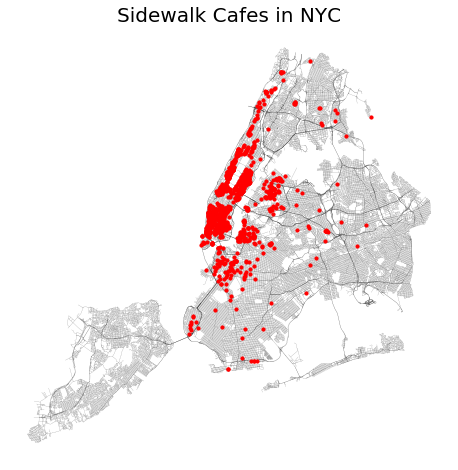

In [32]:
#Transform to GeoDataFrame
cafes['geometry'] = cafes.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE'],), axis=1)
cafes = gpd.GeoDataFrame(cafes, crs=from_epsg(4326)).to_crs(epsg=2263)

#Remove market with nonsense location (only one)
cafes = cafes[(cafes.LONGITUDE > -76)]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Sidewalk Cafes in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1, alpha=0.5)
#nodes.plot(markersize=0.1, ax= ax)
cafes.plot(color='red', markersize=10, ax=ax)
ax.axis('off')

plt.show()

### II. "Spatially join" to road data 

In [33]:
len(segs), len(cafes)

(91666, 1242)

In [34]:
%time cafes['segid'] = cafes.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 5.99 s, sys: 40 ms, total: 6.03 s
Wall time: 6.02 s


In [35]:
cafes.segid.isna().sum()

0

### III. Aggregate to SoP variables per segment

In [36]:
cafes.columns

Index(['LICENSE_NBR', 'LIC_STATUS', 'BUSINESS_NAME', 'BUSINESS_NAME2',
       'BUILDING', 'STREET', 'CITY', 'STATE', 'ZIP', 'SWC_TYPE', 'SWC_SQ_FT',
       'SWC_TABLES', 'SWC_CHAIRS', 'DOHMH', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_DISTRICT', 'CITY_COUNCIL_DISTRICT', 'CD_URL', 'APP_ID',
       'APP_SWC_TYPE', 'APP_SQ_FT', 'APP_TABLES', 'APP_CHAIRS', 'APP_STATUS',
       'APP_STATUS_DATE', 'EXPIRATION_DATE', 'APP_TOO_DATE', 'SUBMIT_DATE',
       'INTAKE', 'INTAKE_DD', 'DPQA', 'SEND_PACKAGE_DD', 'CP', 'CP_DD', 'CB',
       'CB_DD', 'HEARING', 'HEARING_DD', 'HEARING_PUBLIC', 'HEARING_PUBLIC_DD',
       'CC', 'CC_DD', 'MOO', 'MOO_DD', 'ISSUANCE', 'ISSUANCE_DD', 'geometry',
       'segid'],
      dtype='object')

In [48]:
cafes.APP_CHAIRS.value_counts()

Series([], Name: APP_CHAIRS, dtype: int64)

In [37]:
cafes.groupby('segid')['BUSINESS_NAME'].count().describe()

count    930.000000
mean       1.335484
std        0.766163
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: BUSINESS_NAME, dtype: float64

Most of them are 1...

In [76]:
cafes_var = cafes.groupby('segid')[['BUSINESS_NAME']].count()
cafes_var.columns = ['dining']
cafes_var['dining'] = cafes_var.dining.apply(lambda x: 2 if x > few else 1 if x > 0 else 0)
cafes_var.head()

,dining
segid,
116,1
130,1
247,1
553,1
833,1


In [77]:
cafes_var.dining.value_counts()

1    913
2     17
Name: dining, dtype: int64

In [80]:
# cafes_var = pd.DataFrame(index=cafes.segid.unique(), columns=['dining']).fillna(1)
# cafes_var.index.name = 'segid'
# cafes_var.head()

## CityRacks ##

Answer should be:

- Some/A lot: 2
- Few: 1
- None: 0

What does few vs some/a lot mean in this case?

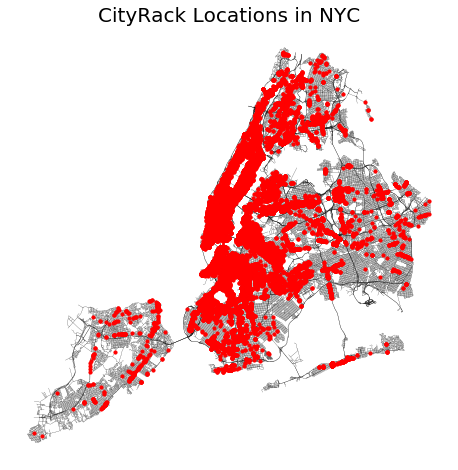

In [49]:
# Get racks from CSV
racks = pd.read_csv('Datasets (from NYC open data)/BicycleParking.csv')

#Transform to GeoDataFrame
racks['geometry'] = racks.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
racks = gpd.GeoDataFrame(racks, crs=from_epsg(4326)).to_crs(epsg=2263)

#Remove market with nonsense location (only one)
racks = racks[(racks.Latitude > 0)]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('CityRack Locations in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
#nodes.plot(markersize=0.1, ax= ax)
racks.plot(color='red', markersize=10, ax=ax)
ax.axis('off')

plt.show()

### II. "Spatially join" to road data 

In [50]:
len(segs), len(racks)

(91666, 26259)

In [51]:
%time racks['segid'] = racks.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 1min 51s, sys: 910 ms, total: 1min 52s
Wall time: 1min 52s


In [52]:
racks.segid.isna().sum()

0

### III. Aggregate to SoP variables per segment

In [53]:
racks.columns

Index(['the_geom', 'SITE_ID', 'CD', 'Borough', 'BBL', 'House__', 'Street_Nam',
       'Street_On', 'From_Stree', 'To_Street', 'Side_of_St', 'Asset_Type',
       'Latitude', 'Longitude', 'geometry', 'segid'],
      dtype='object')

In [54]:
racks.Asset_Type.value_counts()

Bike Rack    26259
Name: Asset_Type, dtype: int64

In [55]:
racks.groupby('segid')['SITE_ID'].count().describe()

count    7333.000000
mean        3.580935
std         3.711486
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        52.000000
Name: SITE_ID, dtype: float64

Ok, here it makes more sense.

In [78]:
racks_var = racks.groupby('segid')[['SITE_ID']].count()
racks_var.columns = ['bikerack']
racks_var['bikerack'] = racks_var.bikerack.apply(lambda x: 2 if x > few else 1 if x > 0 else 0)
racks_var.head()

,bikerack
segid,
17,1
49,1
50,2
52,2
60,1


In [79]:
racks_var.bikerack.value_counts()

1    4815
2    2518
Name: bikerack, dtype: int64

In [82]:
# racks_var = pd.DataFrame(index=racks.segid.unique(), columns=['bikerack']).fillna(1)
# racks_var.index.name = 'segid'
# # racks_var.head()

## Street Cleanliness ##

## Leading Pedestrian Signs ##


Yes/No answers

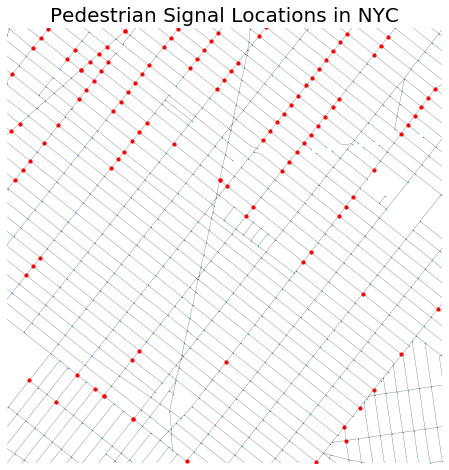

In [83]:
# Get racks from CSV
signals = pd.read_csv('Datasets (from NYC open data)/dot_VZV_Leading_Pedestrian_Intervals_20190621.csv')

#Transform to GeoDataFrame
signals['geometry'] = signals.apply(lambda x: Point(x['LONG'], x['LAT']), axis=1)
signals = gpd.GeoDataFrame(signals, crs=from_epsg(4326)).to_crs(epsg=2263)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Pedestrian Signal Locations in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
nodes.plot(markersize=0.1, ax= ax)
signals.plot(color='red', markersize=10, ax=ax)

ax.set_xlim(980000, 990000)
ax.set_ylim(160000, 170000)
ax.axis('off')

plt.show()

### II. "Spatially join" to road data 

Because its at the interection, it should be assigned to all connecting segments. Also not sure leading pedestrian sign = all those SoP variables. There is one SoP variables for each intersection so we can do both with this.

In [84]:
len(segs), len(signals)

(91666, 3612)

In [85]:
signals_buff = signals.copy()
signals_buff['geometry'] = signals_buff.geometry.buffer(25)

In [86]:
signals_joined = gpd.sjoin(signals_buff, segs, how='right')

/opt/conda/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:2263', 'no_defs': True} != {'init': 'epsg:2263'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [87]:
signals_joined.index_left.nunique()

3603

9 signals weren't joined to any segment.

In [88]:
signals_var = signals_joined.groupby('id')[['index_left']].nunique()
signals_var.index.name = 'segid'
signals_var.head()

,index_left
segid,
1,0
2,0
3,0
4,0
5,0


In [89]:
signals_var.index_left.value_counts()

0     81055
1      7729
2      2706
3       133
4        36
5         3
27        1
14        1
10        1
6         1
Name: index_left, dtype: int64

I guess the ones that have more than one are highways?

In [90]:
signals_var.index_left = signals_var.index_left.apply(lambda x: x if x < 2 else 2)
signals_var.index_left.value_counts()

0    81055
1     7729
2     2882
Name: index_left, dtype: int64

The ones with 2 should have both corresponding SoP variables set as 1

### III. Aggregate to SoP variables per segment

In [91]:
sop_vars_1 = ['pedauto', 'pedactsgn', 'pedcntdwn', 'pedcrssgn']
sop_vars_2 = ['pedact2', 'pedauto2', 'pedcntdwn2', 'pedcrs2']

In [92]:
for var in sop_vars_1:
    signals_var[var] = signals_var.index_left.apply(lambda x: 1 if x > 0 else 0)
for var in sop_vars_2:
    signals_var[var] = signals_var.index_left.apply(lambda x: 1 if x > 1 else 0)

In [93]:
signals_var[signals_var.index_left == 1].head()

,index_left,pedauto,pedactsgn,pedcntdwn,pedcrssgn,pedact2,pedauto2,pedcntdwn2,pedcrs2
segid,,,,,,,,,
16,1,1,1,1,1,0,0,0,0
17,1,1,1,1,1,0,0,0,0
118,1,1,1,1,1,0,0,0,0
121,1,1,1,1,1,0,0,0,0
122,1,1,1,1,1,0,0,0,0


In [94]:
signals_var[signals_var.index_left == 2].head()

,index_left,pedauto,pedactsgn,pedcntdwn,pedcrssgn,pedact2,pedauto2,pedcntdwn2,pedcrs2
segid,,,,,,,,,
78,2,1,1,1,1,1,1,1,1
180,2,1,1,1,1,1,1,1,1
181,2,1,1,1,1,1,1,1,1
182,2,1,1,1,1,1,1,1,1
183,2,1,1,1,1,1,1,1,1


In [95]:
signals_var.drop('index_left', axis=1, inplace=True)
signals_var.head()

,pedauto,pedactsgn,pedcntdwn,pedcrssgn,pedact2,pedauto2,pedcntdwn2,pedcrs2
segid,,,,,,,,
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0


## Speed Humps

Yes/No answers

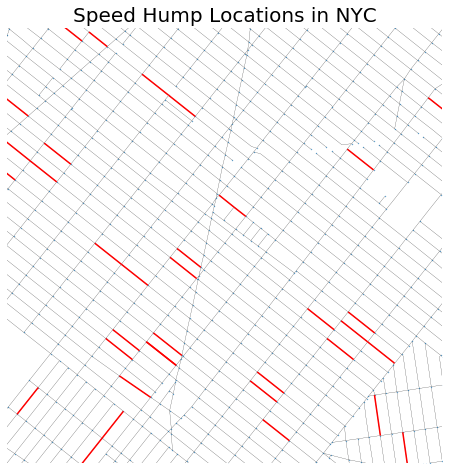

In [96]:
# Get ped signals 
humps = gpd.read_file('Datasets (from NYC open data)/speed_hump.shp').pipe(lambda x: x[~x.geometry.isna()]).to_crs({'init': 'epsg:2263'})

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Speed Hump Locations in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
nodes.plot(markersize=0.1, ax= ax)
humps.plot(color='red', markersize=10, ax=ax)

ax.set_xlim(980000, 990000)
ax.set_ylim(160000, 170000)
ax.axis('off')

plt.show()

In [97]:
humps.head()

,date_date_,time_date_,from_st,new_humps,on_st,shape_leng,to_st,geometry
0,2014-05-22,00:00:00.000,6 AVENUE,2.0,1 STREET,775.659477,7 AVENUE,LINESTRING (989820.9370088868 184417.365138917...
1,2017-09-11,00:00:00.000,HOYT STREET,2.0,1 STREET,652.150192,BOND STREET,LINESTRING (986206.1706163876 186652.842623344...
2,2011-12-15,00:00:00.000,100 DR./220 STREET,1.0,100 AVENUE,423.930065,SPRINGFIELD BL.,LINESTRING (1057545.654905634 199860.991731916...
3,1996-08-01,00:00:00.000,FOURTH AVE,1.0,100 ST,591.886182,FT HAMILTON PKWY,LINESTRING (974908.018015891 162549.8567086612...
4,2004-06-17,00:00:00.000,Northern Boulevard,1.0,100 Street,673.502404,34TH Avenue,LINESTRING (1020685.559334632 215221.593556587...


In [98]:
len(humps)

2915

### Spatial join

In [99]:
def better_representative_point(linestring):
    if linestring.centroid.buffer(25).intersects(linestring):
        return linestring.centroid
    else:
        return Point(linestring.coords[len(linestring.coords)//2])

In [100]:
#make a buffer on streets centroid (or inner coordinate if line is not straight)
segs_buff = segs.copy()
segs_buff['geometry'] = segs_buff.geometry.apply(lambda x: better_representative_point(x).buffer(25))

In [101]:
humps_joined = gpd.sjoin(humps, segs_buff, how='right')

In [102]:
(~humps_joined.index_left.isna()).sum()

4783

In [103]:
humps_joined.index_left.nunique()

2887

Only a few humps were not joined into a segment

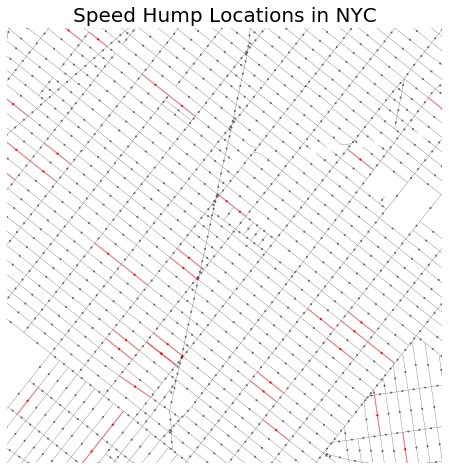

In [104]:
# Get ped signals 
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Speed Hump Locations in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
humps_joined[humps_joined.index_left.isna()].plot(color='black', ax= ax, lw=0.2, zorder=3, markersize=10, alpha=0.5)
humps_joined[~humps_joined.index_left.isna()].plot(color='red', ax= ax, lw=0.2, zorder=3, markersize=10)
#nodes.plot(markersize=0.1, ax= ax)
humps.plot(color='red', ax=ax, alpha=0.3)

ax.set_xlim(980000, 990000)
ax.set_ylim(160000, 170000)
ax.axis('off')

plt.show()

Looks fine to me

In [105]:
humps_var = (humps_joined.groupby('id')[['index_left']].count() >= 1).astype(int)
humps_var.index.name = 'segid'
humps_var.columns = ['spdbump']
humps_var.head()

,spdbump
segid,
1,0
2,0
3,0
4,0
5,0


In [106]:
humps_var.spdbump.value_counts()

0    87087
1     4579
Name: spdbump, dtype: int64

## Parks

I think we are getting these from PLUTO

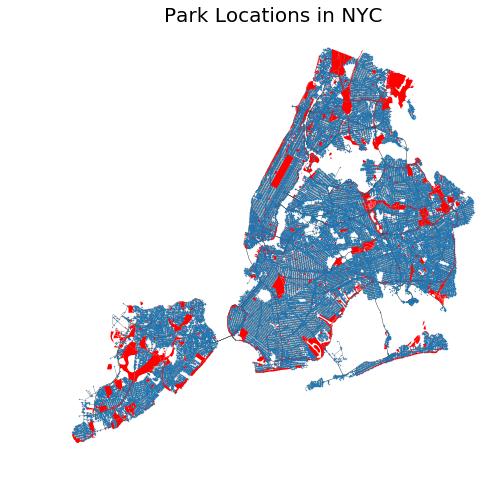

In [212]:
# # Get parks
# parks = gpd.read_file('parks.shp').to_crs({'init': 'epsg:2263'})

# fig, ax = plt.subplots(figsize=(12,8))
# ax.set_title('Park Locations in NYC', fontsize=20)
# segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
# nodes.plot(markersize=0.1, ax= ax)
# parks.plot(color='red', markersize=10, ax=ax)
# ax.axis('off')

# plt.show()

# Join all and save

In [107]:
final_df = pd.merge(humps_var, signals_var, right_index=True, left_index=True, how='outer')
final_df = pd.merge(final_df, racks_var, right_index=True, left_index=True, how='outer')
final_df = pd.merge(final_df, cafes_var, right_index=True, left_index=True, how='outer')
final_df = pd.merge(final_df, benches_var, right_index=True, left_index=True, how='outer')
final_df = pd.merge(final_df, shelters_var, right_index=True, left_index=True, how='outer')
final_df = pd.merge(final_df, markets_var, right_index=True, left_index=True, how='outer')
final_df = final_df.fillna(0).astype(int)
final_df.head()

,spdbump,pedauto,pedactsgn,pedcntdwn,pedcrssgn,pedact2,pedauto2,pedcntdwn2,pedcrs2,bikerack,dining,benches,busstops,farnermk
segid,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [108]:
final_df.to_csv('joined_nyc_open_data.csv')

# Plot all variables

In [109]:
variables = list(final_df.columns)

segs_joined = pd.merge(segs, final_df, left_on='id', right_index=True, how='left', suffixes=('_x', '')).fillna(0)
segs_joined[variables] = segs_joined[variables].astype(int)

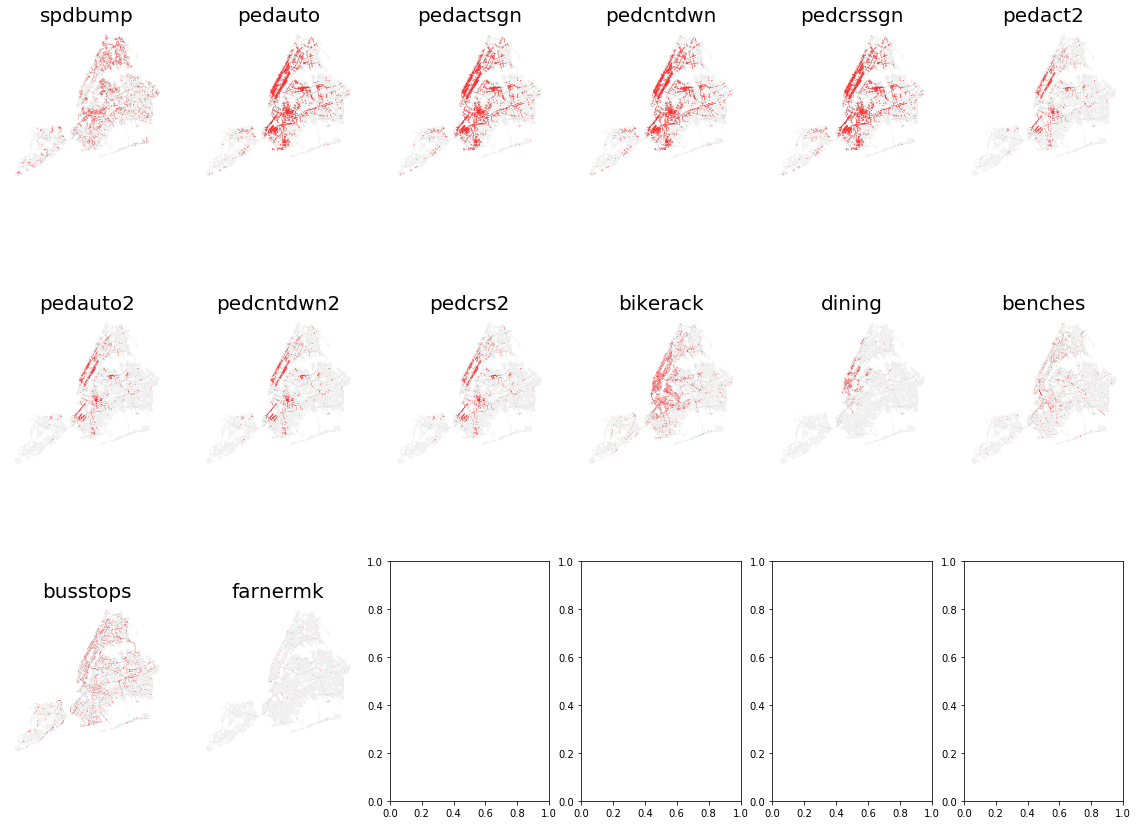

In [110]:
fig, axes = plt.subplots(ncols=6, nrows=3, figsize=(20,15))

for i, var in enumerate(variables):
    ax = axes.flatten()[i]
    segs_joined[segs_joined[var] == 1].plot(color='red', ax= ax, lw=0.3, zorder=-1, alpha=1)
    segs_joined[segs_joined[var] == 0].plot(color='grey', ax= ax, lw=0.1, zorder=-1, alpha=0.3)
    ax.set_title(var, fontsize=20)
    ax.axis('off')

plt.show()